In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from sys import path
path.insert(0, "lib")

In [7]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

In [8]:
from lib.onedmodel import *

In [13]:
nSGD = 10**3
nsamples = 10**4
shuffle = True
batch_size= 20
w0 = 1
model = PolyModel(w0=w0)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, shuffle=shuffle, batch_size=batch_size, auto=True)
df_auto = sgd_runner.generate_trajectories(model)

trajectory 0 over 1000


(0.001, 1)

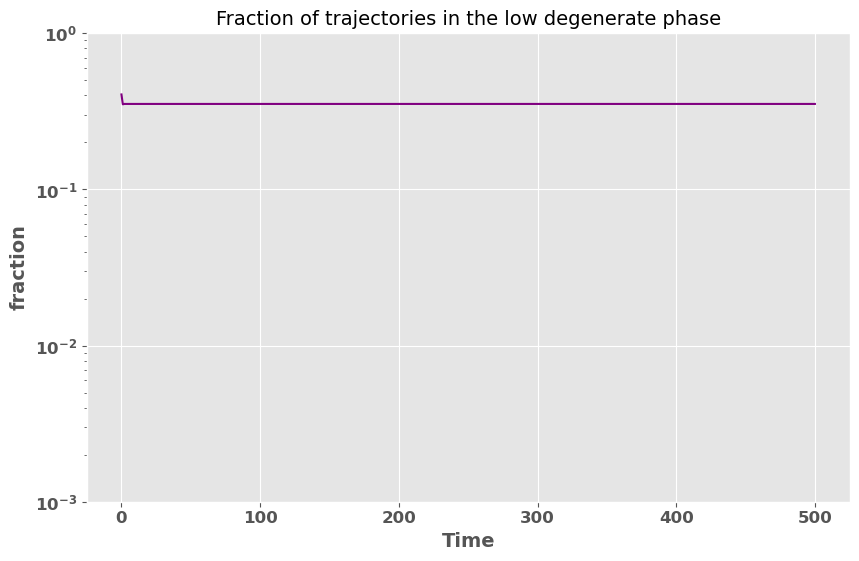

In [14]:
# Plot rate of escape
%matplotlib inline
# Plot phase change
wmax = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)
trajectories = df_auto['trajectory'].to_list()
trajectories = np.asarray(trajectories)
end_traj = trajectories[:,-1]
phases = np.zeros_like(trajectories)
phases[trajectories - wmax > 0] = 1
phases[trajectories - wmax < 0] = -1

fraction_regular_phase = np.sum(phases == -1,axis=0)/phases.shape[0]
fraction_singular_phase = np.sum(phases == 1,axis=0)/phases.shape[0]

nit = len(fraction_regular_phase)
time = np.arange(0, nit,1)

plt.plot(time, fraction_regular_phase[time], color="purple")
#plt.plot(time, fraction_singular_phase[time], label = "low RLCT", color="orange")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase")
plt.ylim((0.001,1))

In [15]:
# Trajectories with old code
from lib.SGD_utils import *

d1 = 1
d2 = 2
lr = 0.01
batch_size = 30
nsamp = 10**3
num_trajectories = 10**4
niterations = 10**2

# Change a and b to play with the potential barrier
b = 2 # Singular 
a = -b # regular
wmax = (a*d2 + b*d1)/(d1 + d2)
wm = 2*a
barrier = q(wmax, d1 ,d2, a,b)**2
trajectories = []

print(f"The local maximum is at {wmax} abd the height of the barrier is {barrier}")

for i in range(num_trajectories):
    if i % 1000 == 0:
        print(f"trajectory {i} over {num_trajectories}")
    seed = i
    w_init = df_auto['w_init'].iloc[i]
    # maybe seed here?
    L = SGD(lr, q, grad_q, w_init, nsamp, batch_size, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

The local maximum is at -0.6666666666666666 abd the height of the barrier is 89.89849108367629
trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 7000 over 10000
trajectory 8000 over 10000
trajectory 9000 over 10000


In [22]:
# Compare man, auto and old
old_traj = trajectories
man_traj = df["trajectory"].to_list()
auto_traj = df_auto["trajectory"].to_list()
print(old_traj[1,5])
print(man_traj[1][5])
print(auto_traj[1][5])

1.9182036601897698
1.7748584747314453
1.8043907704427753


In [15]:
# Plot rate of escape
%matplotlib inline
# Plot phase change
wmax = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)

trajectories = df['trajectory'].to_list()
trajectories = np.asarray(trajectories)
end_traj = trajectories[:,-1]
phases = np.zeros_like(trajectories)
phases[trajectories - wmax > 0] = 1
phases[trajectories - wmax < 0] = -1

fraction_regular_phase = np.sum(phases == -1,axis=0)/phases.shape[0]
fraction_singular_phase = np.sum(phases == 1,axis=0)/phases.shape[0]

nit = len(fraction_regular_phase)
time = np.arange(0, nit,1)

plt.plot(time, fraction_regular_phase[time], color="purple")
#plt.plot(time, fraction_singular_phase[time], label = "low RLCT", color="orange")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase")
plt.ylim((0,1))

NameError: name 'df' is not defined

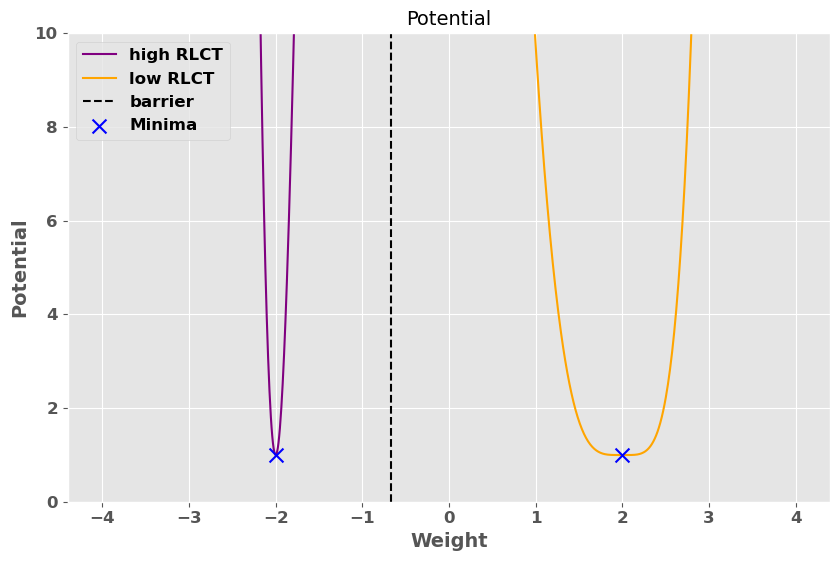

In [18]:
# Plot potential

def theoretical_loss(model: PolyModel, w, x,y):
    loss_function = nn.MSELoss() 
    model.update_params(weight=torch.nn.Parameter(torch.tensor(w)))
    y_pred = model.forward(x)
    return loss_function(y_pred, y).item()

%matplotlib inline
wmax = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)
wm = 2*model.w0
a = float(model.w0)
nsamp = 10**4
x = torch.randn((nsamp, 1, 1))
y = torch.randn((nsamp, 1, 1))
wrange = np.linspace(-wm, wm, 1000)
loss = np.zeros((len(wrange),1))
for i in range(len(wrange)):
    loss[i] = theoretical_loss(model, wrange[i], x, y)

min1 = theoretical_loss(model, -a, x, y)
min2 = theoretical_loss(model, a, x, y)
barrier = theoretical_loss(model, wmax, x, y)
# Split the data at x = b
regular = wrange < wmax
singular = wrange >= wmax

plt.plot(wrange[regular], loss[regular], color="purple", label="high RLCT")
plt.plot(wrange[singular], loss[singular], color="orange", label="low RLCT")

plt.xlabel("Weight")
plt.ylabel("Potential")
plt.axvline(x=wmax, linestyle='--' ,color="k", label="barrier")
plt.scatter([-a, a], [min1, min2], color='blue', s=100, zorder=5, marker='x',label='Minima')
plt.legend()
plt.title("Potential")
plt.ylim((0, 10))
plt.show()

In [19]:
# Look for exploding trajectories

clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
print(len(~np.isnan(trajectories).any(axis=1)))
print(clean_traj.shape)

10000
(6959, 101)


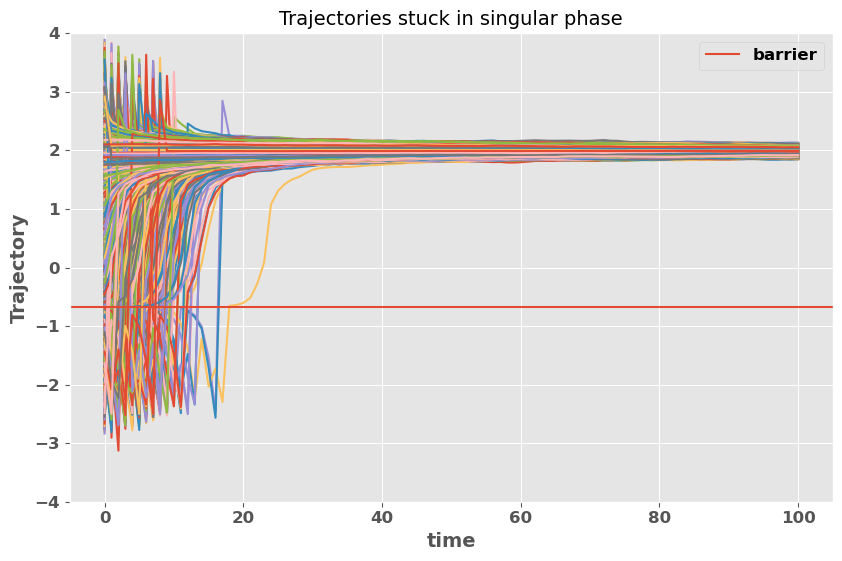

In [27]:
for i in range(len(clean_traj)):
    plt.plot(time, clean_traj[i,:])

plt.ylim((-wm, wm))
plt.axhline(y=wmax, label="barrier")
plt.xlabel("time")
plt.ylabel("Trajectory")
plt.title("Trajectories stuck in singular phase")
plt.legend()

In [6]:
# Run many experiments across parameters

w0_range = np.arange(0.5, 3, 0.5)
batch_range = np.arange(10, 40, 10)
lr_range = [0.1, 0.01, 0.001]

sgd_runner.parameter_sweep(w0_range, batch_range, lr_range, model)

trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 7000 over 10000
trajectory 8000 over 10000
trajectory 9000 over 10000
trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 7000 over 10000
trajectory 8000 over 10000
trajectory 9000 over 10000
trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 7000 over 10000
trajectory 8000 over 10000
trajectory 9000 over 10000
trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 70